# ЫЫЫЫЫЫЫЫЫЫЫЫ

In [15]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt

In [2]:
!pip freeze | grep "numpy\|pandas\|lightgbm\|scikit-learn"

geopandas==0.13.2
lightgbm==4.1.0
numpy==1.25.2
pandas==1.5.3
pandas-datareader==0.10.0
pandas-gbq==0.19.2
pandas-stubs==1.5.3.230304
scikit-learn==1.2.2
sklearn-pandas==2.2.0


## Загрузка данных

In [2]:
train_df = pd.read_parquet("train_data.pqt")
test_df = pd.read_parquet("test_data.pqt")

In [18]:
train_df.head(3)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.951166,0.568681,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,"{α, γ}",{other}
1,0,month_2,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.948812,0.499716,0.785029,0.551904,0.696576,0.990157,0.298873,0.945969,"{α, γ}",{other}
2,0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.946458,0.442244,0.877050,0.551044,0.663243,0.810065,0.294829,0.956958,"{α, γ}",{other}


In [28]:
train_df.describe(include="all")

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
count,600000.000000,600000,5.344230e+05,5.344230e+05,5.344230e+05,5.344230e+05,557150,521656,521656,274776,...,434748.000000,434748.000000,6.000000e+05,434748.000000,434748.000000,6.000000e+05,434748.000000,434748.000000,600000,600000
unique,NaN,3,NaN,NaN,NaN,NaN,45,8917,7931,233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,17
top,NaN,month_1,NaN,NaN,NaN,NaN,channel_code_8,city_0,city_type_0,index_city_code_46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{α},{α}
freq,NaN,200000,NaN,NaN,NaN,NaN,102296,86234,464866,9548,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,375947,318670
mean,99999.500000,NaN,5.291614e-18,-7.312532e-17,-3.959403e-17,-9.945043e-18,NaN,NaN,NaN,NaN,...,0.946172,0.410920,3.422448e-18,0.551292,0.507565,4.041212e-17,0.255424,0.456226,NaN,NaN
std,57735.075031,NaN,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,NaN,NaN,NaN,NaN,...,0.011519,0.080259,1.000001e+00,0.014255,0.156156,1.000001e+00,0.017320,0.136101,NaN,NaN
min,0.000000,NaN,-1.567780e-01,-2.049624e-01,-1.259950e-01,-1.563145e-01,NaN,NaN,NaN,NaN,...,0.944497,0.384773,-1.655883e-01,0.546889,0.407687,-2.011323e-01,0.250924,0.374540,NaN,NaN
25%,49999.750000,NaN,-1.560927e-01,-2.042761e-01,-1.259122e-01,-1.556526e-01,NaN,NaN,NaN,NaN,...,0.944497,0.384773,-1.655881e-01,0.546889,0.407687,-2.011227e-01,0.250924,0.374540,NaN,NaN
50%,99999.500000,NaN,-1.499485e-01,-1.903097e-01,-1.248704e-01,-1.495861e-01,NaN,NaN,NaN,NaN,...,0.944497,0.384773,-1.655881e-01,0.547176,0.429909,-2.011227e-01,0.251501,0.396518,NaN,NaN
75%,149999.250000,NaN,-1.033781e-01,-1.063255e-01,-1.124800e-01,-1.033203e-01,NaN,NaN,NaN,NaN,...,0.944889,0.396267,-1.436181e-01,0.549755,0.541020,-1.384441e-01,0.254101,0.473441,NaN,NaN


In [5]:
test_df.head(3)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster
0,200000,month_4,-0.155447,-0.203866,-0.122699,-0.154980,channel_code_0,city_0,city_type_0,None,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}
1,200000,month_5,-0.155452,-0.203966,-0.122699,-0.154984,channel_code_0,city_0,city_type_0,None,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}
2,200000,month_6,-0.155452,-0.203966,-0.122699,-0.154984,channel_code_0,city_0,city_type_0,None,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,None


In [3]:
cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "start_cluster",
    "index_city_code", "ogrn_month", "ogrn_year",
]

Обозначение категориальных признаков

In [4]:
train_df[cat_cols] = train_df[cat_cols].astype("category")
test_df[cat_cols] = test_df[cat_cols].astype("category")

In [5]:
df_num = train_df.select_dtypes(include=[np.number])
numeric_cols = df_num.columns.values

for col in numeric_cols:
    missing = train_df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:
        print('imputing missing values for: {}'.format(col))
        train_df['{}_ismissing'.format(col)] = missing
        med = train_df[col].median()
        train_df[col] = train_df[col].fillna(med)



df_num_2 = test_df.select_dtypes(include=[np.number])
numeric_cols_2 = df_num_2.columns.values

for col in numeric_cols_2:
    missing = test_df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:
        print('imputing missing values for: {}'.format(col))
        train_df['{}_ismissing'.format(col)] = missing
        med = train_df[col].median()
        train_df[col] = train_df[col].fillna(med)

imputing missing values for: balance_amt_avg
imputing missing values for: balance_amt_max
imputing missing values for: balance_amt_min
imputing missing values for: balance_amt_day_avg
imputing missing values for: ogrn_days_end_month
imputing missing values for: ogrn_days_end_quarter
imputing missing values for: ft_registration_date
imputing missing values for: max_founderpres
imputing missing values for: min_founderpres
imputing missing values for: ogrn_exist_months
imputing missing values for: sum_of_paym_2m
imputing missing values for: sum_of_paym_6m
imputing missing values for: sum_of_paym_1y
imputing missing values for: cnt_a_oper_1m
imputing missing values for: cnt_b_oper_1m
imputing missing values for: cnt_c_oper_1m
imputing missing values for: cnt_deb_d_oper_1m
imputing missing values for: cnt_cred_d_oper_1m
imputing missing values for: cnt_deb_e_oper_1m
imputing missing values for: cnt_days_deb_e_oper_1m
imputing missing values for: cnt_cred_e_oper_1m
imputing missing values fo

C:\Users\User\AppData\Local\Temp\ipykernel_2108\4079182862.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\4079182862.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\4079182862.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

imputing missing values for: cnt_deb_g_oper_3m
imputing missing values for: cnt_days_deb_g_oper_3m
imputing missing values for: cnt_cred_g_oper_3m
imputing missing values for: cnt_days_cred_g_oper_3m
imputing missing values for: cnt_deb_h_oper_3m
imputing missing values for: cnt_days_deb_h_oper_3m
imputing missing values for: cnt_cred_h_oper_3m
imputing missing values for: cnt_days_cred_h_oper_3m


C:\Users\User\AppData\Local\Temp\ipykernel_2108\4079182862.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\4079182862.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\4079182862.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

imputing missing values for: balance_amt_avg
imputing missing values for: balance_amt_max
imputing missing values for: balance_amt_min
imputing missing values for: balance_amt_day_avg
imputing missing values for: ogrn_days_end_month
imputing missing values for: ogrn_days_end_quarter
imputing missing values for: ft_registration_date
imputing missing values for: max_founderpres
imputing missing values for: min_founderpres
imputing missing values for: ogrn_exist_months
imputing missing values for: sum_of_paym_2m
imputing missing values for: sum_of_paym_6m
imputing missing values for: sum_of_paym_1y
imputing missing values for: cnt_a_oper_1m
imputing missing values for: cnt_b_oper_1m
imputing missing values for: cnt_c_oper_1m
imputing missing values for: cnt_deb_d_oper_1m
imputing missing values for: cnt_cred_d_oper_1m
imputing missing values for: cnt_deb_e_oper_1m
imputing missing values for: cnt_days_deb_e_oper_1m
imputing missing values for: cnt_cred_e_oper_1m
imputing missing values fo

In [6]:
df_non_numeric = train_df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values

for col in non_numeric_cols:
    missing = train_df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  # only do the imputation for the columns that have missing values.
        print('imputing missing values for: {}'.format(col))
        train_df['{}_ismissing'.format(col)] = missing
        
        top = train_df[col].describe()['top'] # impute with the most frequent value.
        train_df[col] = train_df[col].fillna(top)

imputing missing values for: channel_code
imputing missing values for: city
imputing missing values for: city_type
imputing missing values for: index_city_code
imputing missing values for: ogrn_month
imputing missing values for: ogrn_year
imputing missing values for: okved
imputing missing values for: segment
imputing missing values for: balance_amt_avg_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

imputing missing values for: balance_amt_max_ismissing
imputing missing values for: balance_amt_min_ismissing
imputing missing values for: balance_amt_day_avg_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

imputing missing values for: ogrn_days_end_month_ismissing
imputing missing values for: ogrn_days_end_quarter_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing


imputing missing values for: ft_registration_date_ismissing
imputing missing values for: max_founderpres_ismissing
imputing missing values for: min_founderpres_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

imputing missing values for: ogrn_exist_months_ismissing
imputing missing values for: sum_of_paym_2m_ismissing
imputing missing values for: sum_of_paym_6m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

imputing missing values for: sum_of_paym_1y_ismissing
imputing missing values for: cnt_a_oper_1m_ismissing
imputing missing values for: cnt_b_oper_1m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

imputing missing values for: cnt_c_oper_1m_ismissing
imputing missing values for: cnt_deb_d_oper_1m_ismissing
imputing missing values for: cnt_cred_d_oper_1m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

imputing missing values for: cnt_deb_e_oper_1m_ismissing
imputing missing values for: cnt_days_deb_e_oper_1m_ismissing
imputing missing values for: cnt_cred_e_oper_1m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

imputing missing values for: cnt_days_cred_e_oper_1m_ismissing
imputing missing values for: cnt_deb_f_oper_1m_ismissing
imputing missing values for: cnt_days_deb_f_oper_1m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

imputing missing values for: cnt_cred_f_oper_1m_ismissing
imputing missing values for: cnt_days_cred_f_oper_1m_ismissing
imputing missing values for: cnt_deb_g_oper_1m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

imputing missing values for: cnt_days_deb_g_oper_1m_ismissing
imputing missing values for: cnt_cred_g_oper_1m_ismissing
imputing missing values for: cnt_days_cred_g_oper_1m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

imputing missing values for: cnt_deb_h_oper_1m_ismissing
imputing missing values for: cnt_days_deb_h_oper_1m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing


imputing missing values for: cnt_cred_h_oper_1m_ismissing
imputing missing values for: cnt_days_cred_h_oper_1m_ismissing
imputing missing values for: cnt_a_oper_3m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

imputing missing values for: cnt_b_oper_3m_ismissing
imputing missing values for: cnt_c_oper_3m_ismissing
imputing missing values for: cnt_deb_d_oper_3m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

imputing missing values for: cnt_cred_d_oper_3m_ismissing
imputing missing values for: cnt_deb_e_oper_3m_ismissing
imputing missing values for: cnt_days_deb_e_oper_3m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

imputing missing values for: cnt_cred_e_oper_3m_ismissing
imputing missing values for: cnt_days_cred_e_oper_3m_ismissing
imputing missing values for: cnt_deb_f_oper_3m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

imputing missing values for: cnt_days_deb_f_oper_3m_ismissing
imputing missing values for: cnt_cred_f_oper_3m_ismissing
imputing missing values for: cnt_days_cred_f_oper_3m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

imputing missing values for: cnt_deb_g_oper_3m_ismissing
imputing missing values for: cnt_days_deb_g_oper_3m_ismissing
imputing missing values for: cnt_cred_g_oper_3m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

imputing missing values for: cnt_days_cred_g_oper_3m_ismissing
imputing missing values for: cnt_deb_h_oper_3m_ismissing
imputing missing values for: cnt_days_deb_h_oper_3m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

imputing missing values for: cnt_cred_h_oper_3m_ismissing
imputing missing values for: cnt_days_cred_h_oper_3m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_2108\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing


In [7]:
misss = train_df.isnull()
misss.head(40)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_f_oper_3m_ismissing_ismissing,cnt_days_cred_f_oper_3m_ismissing_ismissing,cnt_deb_g_oper_3m_ismissing_ismissing,cnt_days_deb_g_oper_3m_ismissing_ismissing,cnt_cred_g_oper_3m_ismissing_ismissing,cnt_days_cred_g_oper_3m_ismissing_ismissing,cnt_deb_h_oper_3m_ismissing_ismissing,cnt_days_deb_h_oper_3m_ismissing_ismissing,cnt_cred_h_oper_3m_ismissing_ismissing,cnt_days_cred_h_oper_3m_ismissing_ismissing
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Создаем выборки для валидации и обучения

In [8]:
X = train_df.drop(["id", "date", "end_cluster"], axis=1)
y = train_df["end_cluster"]

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

In [32]:
print(x_train)

        balance_amt_avg  balance_amt_max  balance_amt_min  \
501294        -0.156509        -0.203728        -0.125995   
285039        -0.156745        -0.204938        -0.125914   
47556         -0.149948        -0.190310        -0.124870   
580653        -0.151900        -0.195730        -0.125735   
547794        -0.151549        -0.199588        -0.119804   
...                 ...              ...              ...   
110268        -0.156287        -0.196178        -0.125995   
259178        -0.144212        -0.182970        -0.119285   
365838        -0.149948        -0.190310        -0.124870   
131932        -0.156115        -0.204464        -0.124347   
121958        -0.111009        -0.061238        -0.121245   

        balance_amt_day_avg     channel_code       city    city_type  \
501294            -0.156044   channel_code_8   city_202  city_type_0   
285039            -0.156282   channel_code_7    city_98  city_type_0   
47556             -0.149586   channel_code_8     ci

## Обучение модели

В качестве базовой модели возьмем LGBM обучим на всех признаках

In [12]:
model_1 = CatBoostClassifier(iterations=10, learning_rate=0.1, depth=6, cat_features=cat_cols)
model_1.fit(x_train, y_train)

0:	learn: 2.0596830	total: 15.4s	remaining: 2m 18s
1:	learn: 1.8149415	total: 30.9s	remaining: 2m 3s
2:	learn: 1.6526236	total: 46.8s	remaining: 1m 49s
3:	learn: 1.5318243	total: 1m 3s	remaining: 1m 34s
4:	learn: 1.4379251	total: 1m 20s	remaining: 1m 20s
5:	learn: 1.3625250	total: 1m 37s	remaining: 1m 5s
6:	learn: 1.3005708	total: 1m 54s	remaining: 49s
7:	learn: 1.2467633	total: 2m 11s	remaining: 32.8s
8:	learn: 1.2035343	total: 2m 28s	remaining: 16.5s
9:	learn: 1.1654634	total: 2m 44s	remaining: 0us


In [13]:
accur = model_1.score(x_train, y_train)
print(accur)

0.69738125


In [14]:
imp = model_1.feature_importances_
print(imp)

[ 0.27247927  0.          1.32481755  0.          0.          0.
  0.          0.          0.          0.          0.          0.41773513
  0.          0.27627703  0.26559568  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          3.48972862  3.45396534  0.          0.34777037  0.64396097
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          2.91358404
  0.55665882  0.         21.55152154  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         58.25

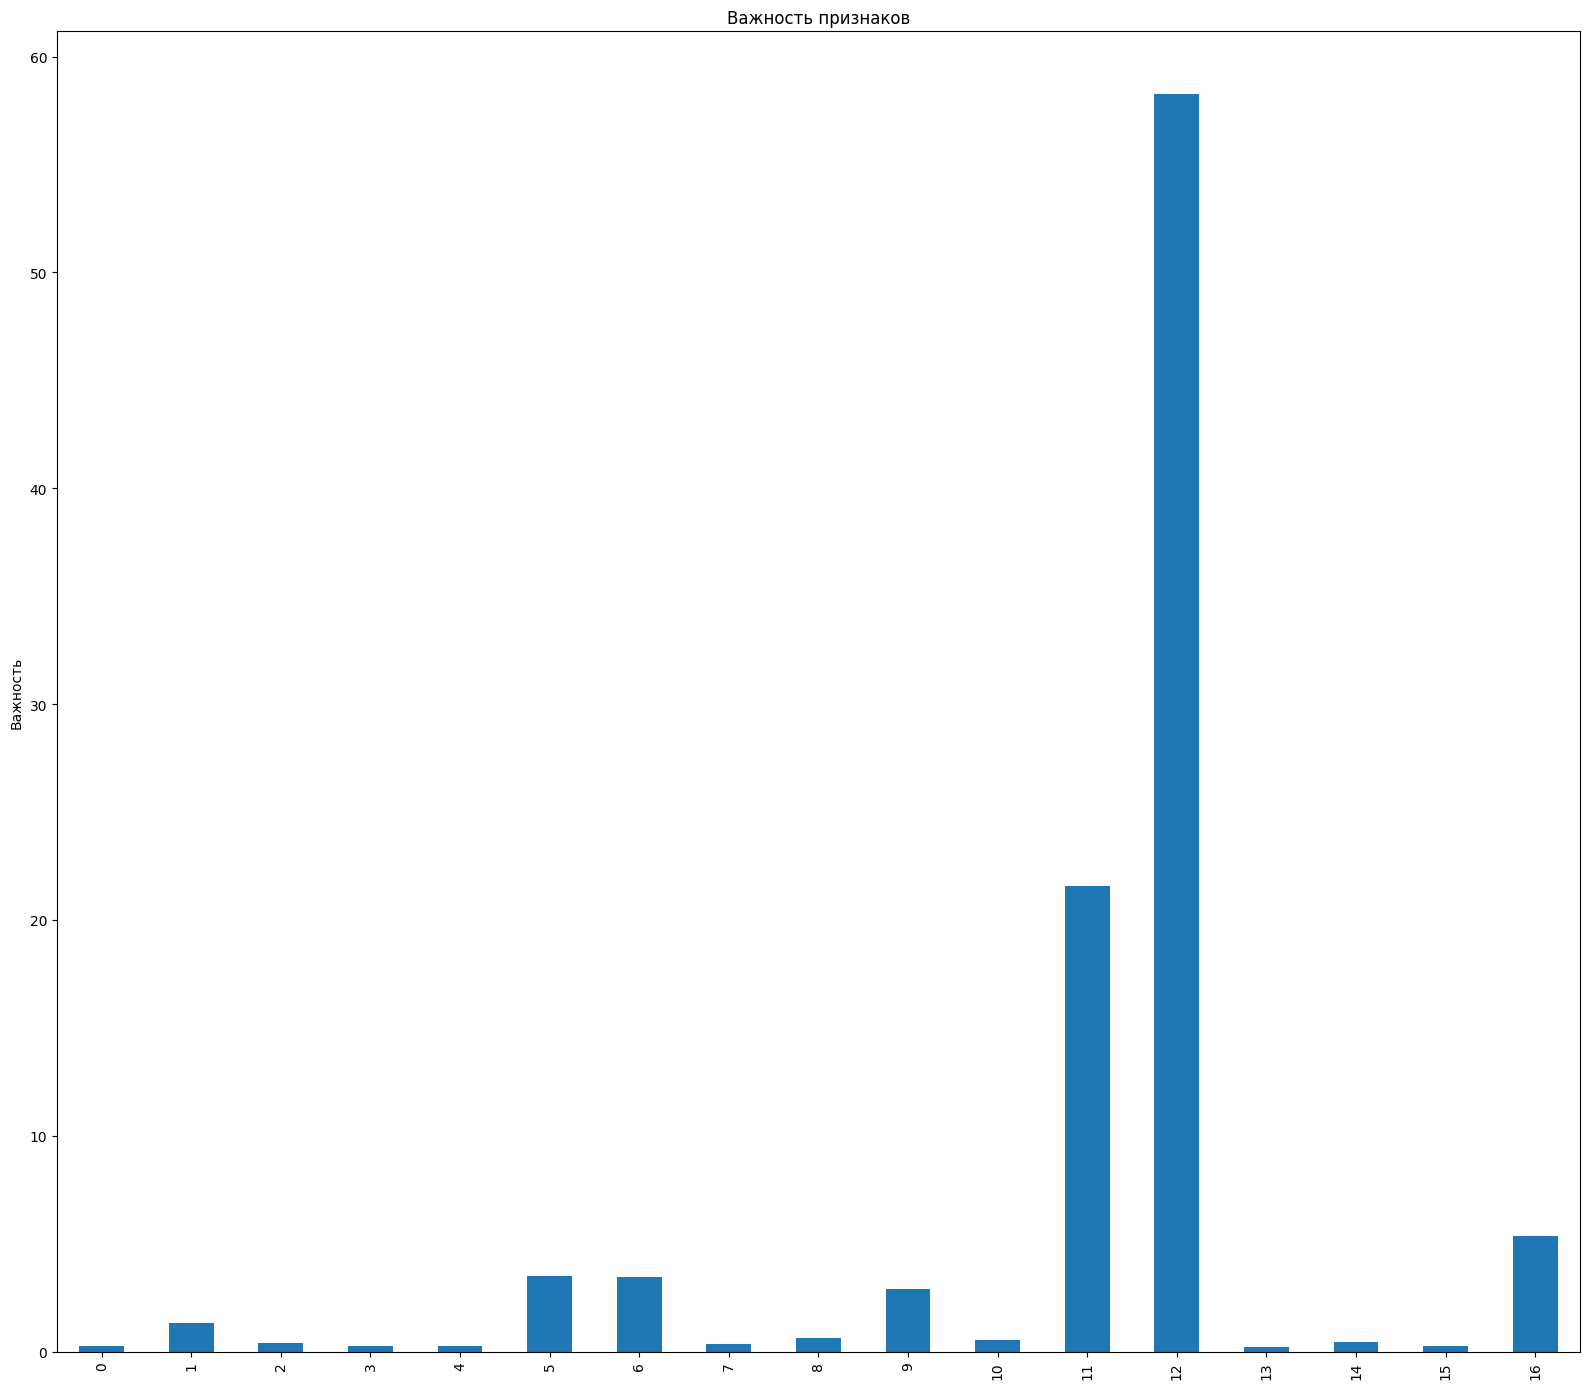

In [50]:
ans = pd.Series(model_1.feature_importances_)
ans_2 = pd.Series([x for x in ans if x > 0])

fig, ax = plt.subplots(figsize=(16,14))
ans_2.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

In [47]:
ans

0      0.272479
1      0.000000
2      1.324818
3      0.000000
4      0.000000
         ...   
203    0.000000
204    0.000000
205    0.000000
206    0.000000
207    0.000000
Length: 208, dtype: float64

In [46]:
print(list(x_train)[0])
print(list(x_train)[2])
print(list(x_train)[11])
print(list(x_train)[13])
print(list(x_train)[14])
print(list(x_train)[31])
print(list(x_train)[32])
print(list(x_train)[34])
print(list(x_train)[35])
print(list(x_train)[65])
print(list(x_train)[66])
print(list(x_train)[68])
print(list(x_train)[89])
print(list(x_train)[146])
print(list(x_train)[148])
print(list(x_train)[149])
print(list(x_train)[150])

balance_amt_avg
balance_amt_min
ogrn_year
max_founderpres
min_founderpres
sum_deb_e_oper_1m
cnt_deb_e_oper_1m
sum_cred_e_oper_1m
cnt_cred_e_oper_1m
sum_deb_e_oper_3m
cnt_deb_e_oper_3m
sum_cred_e_oper_3m
start_cluster
city_ismissing
index_city_code_ismissing
ogrn_month_ismissing
ogrn_year_ismissing


In [51]:
print(list(x_train)[68])

sum_cred_e_oper_3m


In [52]:
print(list(x_train)[66])

cnt_deb_e_oper_3m


In [31]:
cnt = 0
for x in ans:
    if x > 0:
        print(cnt, x)
    cnt += 1

0 0.2724792655863979
2 1.3248175512563223
11 0.41773512549906444
13 0.2762770289561425
14 0.26559567799040174
31 3.4897286224490935
32 3.453965337399339
34 0.3477703714720517
35 0.6439609670341995
65 2.9135840445649874
66 0.5566588229212381
68 21.55152154249567
89 58.25587572610644
146 0.19438010023234206
148 0.44207719747033203
149 0.26258806346124863
150 5.330984555104767


In [9]:
model = LGBMClassifier(verbosity=-1, random_state=42, n_jobs=-1)
model.fit(x_train, y_train)

KeyboardInterrupt: 

Зададим функцию для взвешенной метрики roc auc

In [44]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [48]:
cluster_weights = pd.read_excel("cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

Проверка работы модели

In [49]:
y_pred_proba = model_1.predict_proba(x_val)
y_pred_proba.shape

(120000, 17)

In [50]:
weighted_roc_auc(y_val, y_pred_proba, model_1.classes_, weights_dict)

0.8565139672919543

## Прогноз на тестовой выборке

In [14]:
test_df.pivot(index="id", columns="date", values="start_cluster").head(3)

date,month_4,month_5,month_6
id,,,
200000,{α},{α},NaN
200001,{α},{α},NaN
200002,{α},{α},NaN


Для того, чтобы сделать прогноз на тестовой выборке, нужно заполнить стартовый кластер. </br>
В качестве базового подхода заполним все стартовые кластеры, самым популярным кластером.

In [51]:
test_df["start_cluster"] = train_df["start_cluster"].mode()[0]
test_df["start_cluster"] = test_df["start_cluster"].astype("category")

In [52]:
sample_submission_df = pd.read_csv("sample_submission.csv")

In [53]:
sample_submission_df.shape

(100000, 18)

In [54]:
sample_submission_df.head()

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
1,200001,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
2,200002,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
3,200003,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
4,200004,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05


Для тестовой выборки будем использовать только последний месяц

In [55]:
last_m_test_df = test_df[test_df["date"] == "month_6"]
last_m_test_df = last_m_test_df.drop(["id", "date"], axis=1)

In [57]:
last_m_test_df.head(3)

,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,ogrn_days_end_month,ogrn_days_end_quarter,...,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster
2,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,city_type_0,NaN,-1.533705,-1.683741,...,0.006812,0.945281,0.396267,-0.152800,0.549468,0.541020,0.387566,0.268543,0.836079,{α}
5,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,NaN,0.092087,1.220030,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}
8,-0.048015,0.448252,-0.125995,-0.047215,channel_code_12,city_14,city_type_0,index_city_code_78,-1.069193,-1.528873,...,0.123154,0.946850,0.453739,2.614870,0.565087,0.818798,4.449125,0.258723,0.627287,{α}


In [58]:
test_pred_proba = model.predict_proba(last_m_test_df)
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=model.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

NameError: name 'model' is not defined

In [21]:
test_pred_proba_df.shape

(100000, 17)

In [22]:
test_pred_proba_df.head(2)

,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,0.018570,0.438989,0.001094,0.003762,0.000294,0.000116,1.297136e-07,0.0,0.000829,0.013894,0.001293,5.290471e-11,0.001651,0.0,0.000015,0.519494,0.0
1,0.195437,0.017019,0.043320,0.000162,0.005102,0.000003,6.688079e-05,0.0,0.017252,0.005322,0.015416,7.473112e-08,0.000532,0.0,0.000225,0.700143,0.0


In [23]:
sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("baseline_submission.csv", index=False)